## **Implementando uma rede neural de regressão simples para previsão do resfriamento**

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [21]:
np.random.seed(42)
torch.manual_seed(42)

In [22]:
# ------------------------------------------------------------------------------
# Equação de resfriamento.
# (Os métodos aqui implementados podem ser aplicados para quaisquer EDO.)
# Para cada intervalo de tempo, T(t) apresenta um valor diferente dado por
# r, que é a taxa de resfriamento, menos Ta que é a temperatura ambiente
# mantida constante.
# ------------------------------------------------------------------------------

def df(t,T):
  return r * (Ta - T)

# ------------------------------------------------------------------------------
# Vamos definir a solução analítica para fins de comparação posterior.
# Essa solução pode ser obtida por meio do método de fator integrante,
# vide Apêndice A.
# ------------------------------------------------------------------------------

def f(t,T):
  return Ta + (T0 - Ta) * np.exp(-r*t)

In [23]:
# ------------------------------------------------------------------------------
# Definição das constantes e aplicação do método para aproximar solução.
# Cálculo da solução analítica.
# ------------------------------------------------------------------------------

r = 0.005 # taxa de resfriamento
Ta = 25 # temperatura ambiente (°C)
T0 = 100 # temperatura inicial (°C)
h = 20 # passo de iteração
t0 = 0 # tempo inicial (s)
tf = 200 # tempo final (s)

timean = np.arange(t0,1000,0.1) # Parâmetros para o cálculo da solução analítica.
analitica = f(timean,T0) # Solução analítica.

In [35]:
# ------------------------------------------------------------------------------
# Implementando Runge Kutta 4ª ordem.
# ------------------------------------------------------------------------------

def RK4(df,t0,tf,T0,h):

  t_values = np.arange(t0, tf+h, h)
  T_values = [T0]

  T = T0

  for t in t_values[:-1]:

    k1 = df(t,T)
    k2 = df(t + h/2, T + (h/2)*k1)
    k3 = df(t + h/2, T + (h/2)*k2)
    k4 = df(t + h, T + h*k3)

    T = T + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
    T_values.append(T)

  return t_values, T_values

# ------------------------------------------------------------------------------
# Aplicação do método para aproximação da solução.
# ------------------------------------------------------------------------------

time, Temp = RK4(df,t0,tf,T0,h)

# ------------------------------------------------------------------------------
# Acrescentando ruído aos ados de temperatura gerados pela aproximação RK4.
# ------------------------------------------------------------------------------

Temp_ruido = Temp + np.random.normal(0, 0.5, len(Temp))

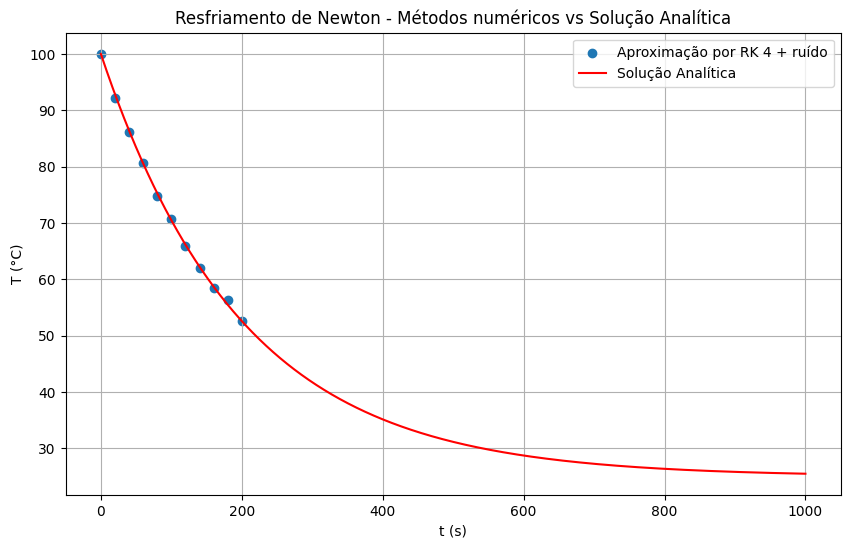

In [36]:
# Plotagem de gráfico para copmaração das curvas/soluções.
# ------------------------------------------------------------------------------

plt.figure(figsize=(10, 6))

plt.scatter(time,Temp_ruido, label = 'Aproximação por RK 4 + ruído')
plt.plot(timean,analitica, label = 'Solução Analítica', c='r')
plt.xlabel('t (s)')
plt.ylabel('T (°C)')
plt.title('Resfriamento de Newton - Métodos numéricos vs Solução Analítica')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# ------------------------------------------------------------------------------
# Gerando dados de treino a partir dos pontos obtidos na aproximação RK4.
# ------------------------------------------------------------------------------

num_samples = len(Temp_ruido)

time_train = time.reshape(-1,1)
Temp_train = Temp_ruido.reshape(-1,1)

# Dados de treino.

x_train = torch.tensor(time_train, dtype=torch.float32)
y_train = torch.tensor(Temp_train, dtype=torch.float32)

In [40]:
# ------------------------------------------------------------------------------
# Implementação do modelo.
# ------------------------------------------------------------------------------

class testenn(nn.Module):
  def __init__(self, hidden_layers=[10,10,10]):

    super(testenn, self).__init__()

    layers = []

    input_size = 1
    for size in hidden_layers:
      layers.append(nn.Linear(input_size, size))

      layers.append(nn.ReLU())

      input_size = size

    layers.append(nn.Linear(input_size, 1))

    self.model = nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

model = testenn(hidden_layers=[10,10,10])

In [42]:
# ------------------------------------------------------------------------------
# Função de perda e otimização do modelo.
# ------------------------------------------------------------------------------

perda = nn.MSELoss()
otimizador = optim.Adam(model.parameters(), lr=0.01)


In [43]:
# ------------------------------------------------------------------------------
# Treinamento da rede.
# ------------------------------------------------------------------------------

epochs = 5000
for epoch in range(epochs):
  model.train()
  otimizador.zero_grad()
  y_pred = model(x_train)
  loss = perda(y_pred, y_train)
  loss.backward()
  otimizador.step()

  if (epoch+1) % 500 == 0:
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f} ")

Epoch [500/5000], Loss: 1.760110 
Epoch [1000/5000], Loss: 1.240747 
Epoch [1500/5000], Loss: 0.803308 
Epoch [2000/5000], Loss: 0.477875 
Epoch [2500/5000], Loss: 0.304729 
Epoch [3000/5000], Loss: 0.819802 
Epoch [3500/5000], Loss: 0.285536 
Epoch [4000/5000], Loss: 0.231632 
Epoch [4500/5000], Loss: 0.200339 
Epoch [5000/5000], Loss: 0.199867 


In [44]:
# ------------------------------------------------------------------------------
# Colocar o modelo para fazer a previsão.
# ------------------------------------------------------------------------------

model.eval()

time_test = np.linspace(0,200,10).reshape(-1,1)
x_test = torch.tensor(time_test, dtype=torch.float32)

with torch.no_grad():
  y_pred = model(x_test).numpy()

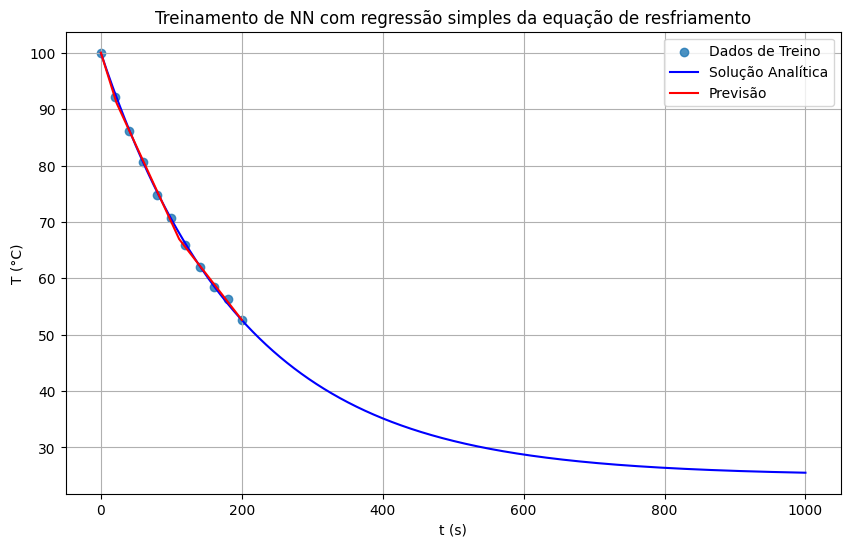

In [47]:
# ------------------------------------------------------------------------------
# Visualização.
# ------------------------------------------------------------------------------

plt.figure(figsize=(10,6))

plt.scatter(time,Temp_ruido, label = 'Dados de Treino', alpha = 0.5)
plt.plot(timean,analitica, label = 'Solução Analítica', c = 'b')
plt.plot(time_test, y_pred, label = 'Previsão', c = 'r')

plt.xlabel('t (s)')
plt.ylabel('T (°C)')
plt.title('Treinamento de NN com regressão simples da equação de resfriamento')
plt.legend()
plt.grid(True)
plt.show()

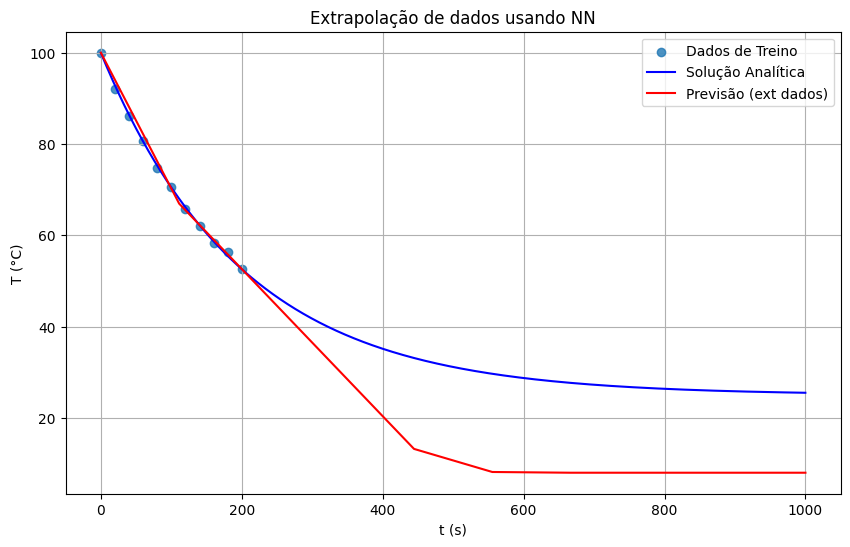

In [59]:
# ------------------------------------------------------------------------------
# Extrapolação dos dados de treino para verificar o comportamento da NN.
# ------------------------------------------------------------------------------

model.eval()

time_test2 = np.linspace(0,1000,10).reshape(-1,1)
x_test2 = torch.tensor(time_test2, dtype=torch.float32)

with torch.no_grad():
  y_pred2 = model(x_test2).numpy()

plt.figure(figsize=(10,6))

plt.scatter(time,Temp_ruido, label = 'Dados de Treino', alpha = 0.8)
plt.plot(timean,analitica, label = 'Solução Analítica', c = 'b')
plt.plot(time_test2, y_pred2, label = 'Previsão (ext dados)', c = 'r')

plt.xlabel('t (s)')
plt.ylabel('T (°C)')
plt.title('Extrapolação de dados usando NN')
plt.legend()
plt.grid(True)
plt.show()